In [1]:
import numpy as np
import fuller
from mpes import analysis as aly
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import tifffile as ti
import matplotlib as mpl
from scipy import interpolate

In [2]:
from imp import reload
reload(fuller)
reload(fuller.utils)
reload(fuller.generator)

<module 'fuller.generator' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\fuller\\generator.py'>

In [3]:
ncfs = 400
bases = fuller.generator.ppz.hexike_basis(nterms=ncfs, npix=208, vertical=True, outside=0)

In [4]:
# Compute the polynomial decomposition coefficients
bandout = np.nan_to_num(fuller.utils.loadHDF(r'.\wse2_lda_bandcuts.h5')['bands'])
bcfs = []
for i in tqdm(range(14)):
    bcfs.append(fuller.generator.decomposition_hex2d(bandout[i,...] + 0.86813, bases=bases, baxis=0, ret='coeffs'))
bcfs = np.array(bcfs)

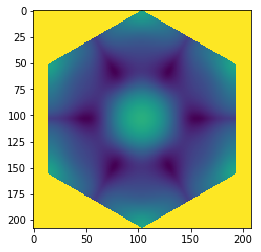

In [5]:
plt.imshow(bandout[0,...])

In [64]:
# Generate Brillouin zone mask
bzmsk = fuller.generator.hexmask(hexdiag=208, imside=208, padded=False, margins=[1, 1, 1, 1])
bzmsk_tight = fuller.generator.hexmask(hexdiag=202, imside=208, padded=True, margins=[3, 3, 3, 3])

In [7]:
nbands = 8

In [8]:
# Generate photoemission data without padding
bshape = (208, 208)
amps = np.ones(bshape)
xs = np.linspace(-4.5, 0.5, 280, endpoint=True)
syndat = np.zeros((280, 208, 208))
gamss = []
for i in tqdm(range(nbands)):
    gams = 0.05
    syndat += aly.voigt(feval=True, vardict={'amp':amps, 'xvar':xs[:,None,None], 'ctr':(bandout[i,...] + 0.86813),
                                        'sig':0.1, 'gam':gams})

In [9]:
# Generate edge-padded bands
synfbands = []
padsize = ((24, 24), (24, 24))
for i in tqdm(range(nbands)): 
    impad = fuller.generator.hexpad(bandout[i,...] + 0.86813, cvd=104, mask=bzmsk, edgepad=padsize)
    synfbands.append(fuller.generator.restore(impad, method='cubic'))
synfbands = np.asarray(synfbands)

In [10]:
# Generate edge-padded photoemission data
bshape = (256, 256)
amps = np.ones(bshape)
xs = np.linspace(-4.5, 0.5, 280, endpoint=True)
synfdat = np.zeros((280, 256, 256))
gamss = []
for i in tqdm(range(nbands)):
#     btemp = np.nan_to_num(synbands[i,...])
#     gams = np.abs(synfbands[i,...] - np.nanmean(synfbands[i,...]))/3
    gams = 0.05
#     gamss.append(gams)
    synfdat += aly.voigt(feval=True, vardict={'amp':amps, 'xvar':xs[:,None,None], 'ctr':(synfbands[i,...]),
                                        'sig':0.1, 'gam':gams})
# gamss = np.asarray(gamss)

In [12]:
xss = np.linspace(-4.5, 0.5, 280, endpoint=True)
xss[1] - xss[0], xss.size

(0.017921146953405298, 280)

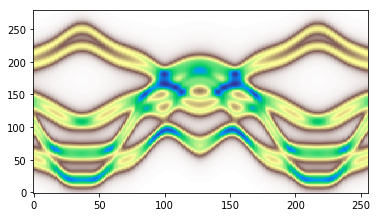

In [11]:
plt.imshow(synfdat[:,80,:], aspect=0.5, origin='lower', cmap='terrain_r')

In [13]:
# Generate mask for large coefficients
cfmask = bcfs.copy()
cfmask[np.abs(cfmask) >= 1e-2] = 1.
cfmask[np.abs(cfmask) < 1e-2] = 0
cfmask[:, 0] = 0 # No rigid shift modulation

In [16]:
# Generate coefficient-scaled data
synfscaled = {}
errs = np.around(np.arange(0.3, 2.01, 0.05), 2)
bscmod = bcfs.copy()

for err in tqdm(errs):
    
    synbands = []
    for i in range(nbands):
        
        bscmod[i, 1:] = err*bcfs[i, 1:] # Scale only the dispersion terms (leave out the first offset term)
        bandmod = fuller.generator.reconstruction_hex2d(bscmod[i, :], bases=bases)
        
        # Sixfold rotational symmetrization
        symmed = fuller.generator.rotosymmetrize(bandmod, center=(104, 104), rotsym=6)[0]
        symmed = fuller.generator.reflectosymmetrize(symmed, center=(104, 104), refangles=[0, 90])
        padded = fuller.generator.hexpad(symmed, cvd=104, mask=bzmsk_tight, edgepad=padsize)
        synbands.append(fuller.generator.restore(padded, method='nearest'))
    
    synfscaled[str(err)] = np.asarray(synbands)

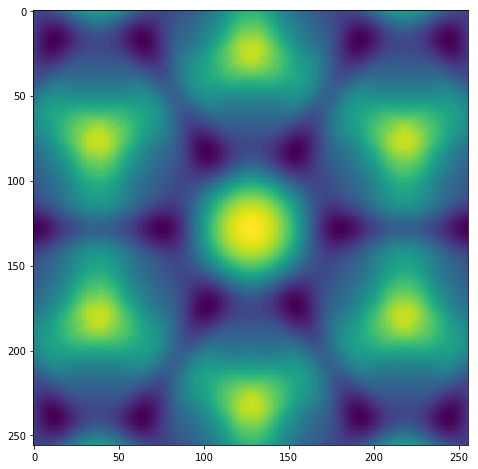

In [19]:
plt.figure(figsize=(8, 8))
plt.imshow(synbands[0])

In [65]:
# Generate coefficient-perturbed data
synfperturbed = {}
noizamp = 0.02
# noizamps = np.asarray([5e-3, 1e-2, 2.5e-2, 5e-2, 7.5e-2, 1e-1, 2.5e-1, 5e-1])
bscmod = bcfs.copy()

for si in tqdm(range(nbands)):
    
    # Generate random perturbation to the coefficients
    np.random.seed(si)
    noiz = fuller.utils.coeffgen((nbands, 400), amp=noizamp, distribution='uniform', modulation='exp',
                                 mask=cfmask[:nbands,:], low=-1, high=1)
    bscmod[:nbands, 1:] += noiz[:, 1:]
    
    synbands = []
    for i in range(nbands):
        bandmod = fuller.generator.reconstruction_hex2d(noiz[i, :], bases=bases)*bzmsk
        bandmod += bandout[i,...]
        
        # Sixfold rotational symmetrization
        symmed = fuller.generator.rotosymmetrize(bandmod, center=(104, 104), rotsym=6)[0]
        symmed = fuller.generator.reflectosymmetrize(symmed, center=(104, 104), refangles=[0, 90])*bzmsk_tight
        padded = fuller.generator.hexpad(symmed, cvd=104, mask=bzmsk_tight, edgepad=padsize)
        synbands.append(fuller.generator.restore(padded, method='nearest'))
    
    synfperturbed[str(si).zfill(2)] = np.asarray(synbands)

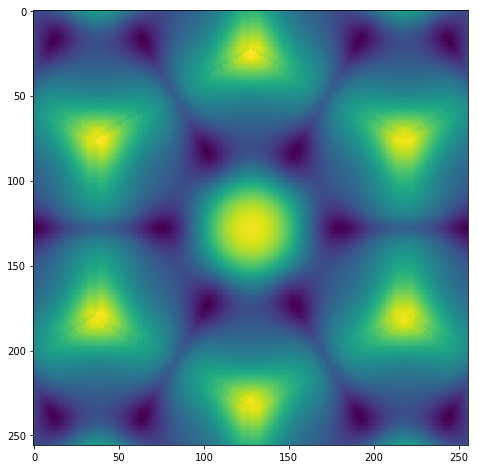

In [66]:
plt.figure(figsize=(8, 8))
plt.imshow(synbands[0])

In [68]:
# Generate coefficient-perturbed data
synfperturbed2 = {}
noizamp = 0.05
# noizamps = np.asarray([5e-3, 1e-2, 2.5e-2, 5e-2, 7.5e-2, 1e-1, 2.5e-1, 5e-1])
bscmod = bcfs.copy()

for si in tqdm(range(nbands)):
    
    # Generate random perturbation to the coefficients
    np.random.seed(si)
    noiz = fuller.utils.coeffgen((nbands, 400), amp=noizamp, distribution='uniform', modulation='exp',
                                 mask=cfmask[:nbands,:], low=-1, high=1)
    bscmod[:nbands, 1:] += noiz[:, 1:]
    
    synbands = []
    for i in range(nbands):
        bandmod = fuller.generator.reconstruction_hex2d(noiz[i, :], bases=bases)*bzmsk
        bandmod += bandout[i,...]
        
        # Sixfold rotational symmetrization
        symmed = fuller.generator.rotosymmetrize(bandmod, (104, 104), rotsym=6)[0]
        symmed = fuller.generator.reflectosymmetrize(symmed, center=(104, 104), refangles=[0, 90])*bzmsk_tight
        padded = fuller.generator.hexpad(symmed, cvd=104, mask=bzmsk_tight, edgepad=padsize)
        synbands.append(fuller.generator.restore(padded, method='nearest'))
    
    synfperturbed2[str(si).zfill(2)] = np.asarray(synbands)

In [75]:
fuller.utils.saveHDF(*[['data', {'bands':bandout[:8,...], 'bands_padded':synfbands, 'mpes':syndat, 'mpes_padded':synfdat}],
                       ['estimates_amp_tuning_padded', synfscaled], 
                       ['estimates_amp=0.02', synfperturbed], ['estimates_amp=0.05', synfperturbed2],
                       ['params', {'coeffs':bcfs, 'basis':bases, 'E':xs, 'amps':amps, 'sig':0.1, 'gam':gams,
                        'kx':axes['axes'][0], 'ky':axes['axes'][1], 'mask':bzmsk, 'mask_tight':bzmsk_tight}]],
                     save_addr=r'./synth_data_test_004_WSe2_LDA_top8.h5')

In [71]:
# Calibrate momentum axes
mc = aly.MomentumCorrector(np.asarray(synbands))

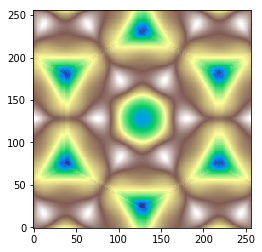

In [72]:
mc.selectSlice2D(selector=slice(0,1), axis=0)
mc.view(mc.slice)

In [73]:
mc.featureExtract(mc.slice, method='daofind', fwhm=30, sigma=20)

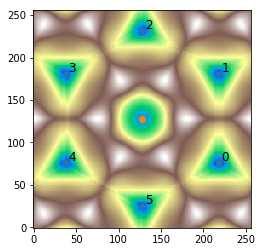

In [74]:
mc.view(mc.slice, annotated=True, points=mc.features)

In [46]:
# Calculate distances
dg = 1.64/np.cos(np.radians(30))
dg

1.8937088829419724

In [47]:
axes = mc.calibrate(mc.slice, mc.pouter_ord[0,:], mc.pcent, dist=dg, equiscale=True, ret='axes')

In [48]:
axes['axes'][0][0], axes['axes'][0][-1]

(-2.3253857612463897, 2.3072186849866503)